# Проверка гипотез по увеличению выручки в интернет-магазине. 
# Оценка результатов A/B-теста

## Описание проекта

**Цель:** Приоритизировать гипотезы, подготовленные вместе с отделом маркетинга для увеличения выручки интернет-магазина. Запустить A/B-тест и проанализировать результаты.

**Описание данных:** 

Файл `/datasets/hypothesis.csv`:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл `/datasets/orders.csv`: 
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
# Выгрузка необходимых библиотек
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Выгрузка массивов данных
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

## Подготовка данных

**Обработка hypothesis:**

In [3]:
pd.options.display.max_colwidth = 300
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


**Обработка orders:**

In [5]:
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
orders = orders.drop_duplicates()
display(orders.info())
display(orders.describe())
print('Начальная дата:', orders['date'].min(), '\nКонечная дата:', orders['date'].max())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 56.1+ KB


None

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Начальная дата: 2019-08-01 00:00:00 
Конечная дата: 2019-08-31 00:00:00


In [7]:
print('Количество пользователей, попавших в обе группы:', 
      orders.query('group == "A"')['visitorId'].isin(orders.query('group == "B"')['visitorId']).sum())

Количество пользователей, попавших в обе группы: 89


**Обработка visitors:**

In [8]:
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [9]:
display(visitors.describe())
visitors.info()

,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Вывод

Были предоставлены 3 массива данных, содержащих информацию о гипотезах, заказах, и количестве пользователей. Для подготовки к дальнейшему анализу потребовалось только изменить названия колонок у `hypothesis`, приведя их к нижнему регистру.

89 пользователей попали в обе группы теста, однако это может быть связано с тем, что при первом заказе была показана одна версия, а при втором - уже другая. Удалять таких пользователей не будем, так как они составляют всего 7% от имеющихся данных в orders и уже учтены в таблице visits.

## Приоритезация гипотез

В `hypothesis` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами reach, impact, confidence, efforts.

Применим фреймворк `ICE` для приоритизации гипотез:
$$ICE = \frac{Impact * Confidence}{Efforts}$$
Отсортируем их по убыванию приоритета.

In [10]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 3)
hypothesis_ICE = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)
hypothesis_ICE

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Применим фреймворк `RICE` для приоритизации гипотез:
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$
Отсортируем их по убыванию приоритета.

In [11]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_RICE = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
hypothesis_RICE

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

После применения фреймворка `ICE` наиболее приоритетными оказались гипотезы `8`, `0`, `7`. 

После применения фреймворка `RICE` наиболее приоритетными оказались гипотезы `7`, `2`, `0`.

Это изменение связано с тем, что во втором варианте учитывается четвертый важный параметр - количество пользователей, которых затронет изменение. Таким образом, наиболее приоритетными выбираем гипотезы `7`, `2`, `0`.

## Анализ A/B-теста

### Кумулятивная выручка по группам

Построим график кумулятивной выручки по группам

In [12]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах
datesGroups = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


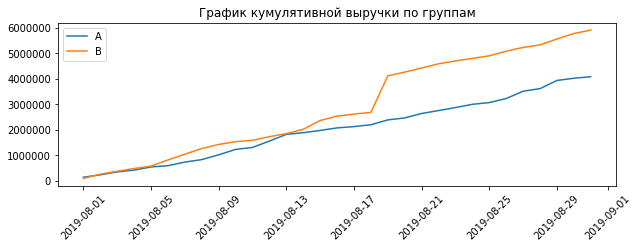

In [13]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10,3))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.show()

**Вывод:**

Выручка почти равномерно растет в обеих группах, однако в группе B она стабильно выше, чем у группы А. После 17-го августа 2019-го года происходит резкое увеличение выручки в группе В, при том что в группе А его нет. Возможно, оно обусловлено аномалиями.

### Кумулятивный средний чек по группам

Построим график кумулятивного среднего чека по группам. 

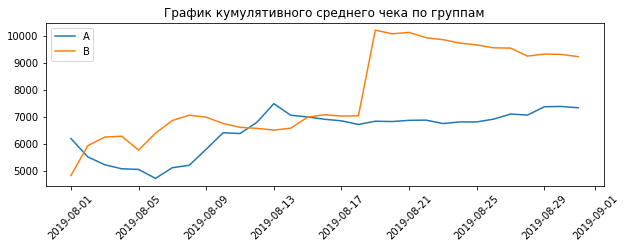

In [14]:
plt.figure(figsize=(10,3))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.show()

**Вывод:**

Средний чек в группе B почти всегда выше, чем у группы А. Однако после 17-го августа 2019-го года наблюдается его резкое увеличение, а в группе А нет. Скорее всего, тут дело в аномалии, потому что после этой же даты так же резко увеличивается кумулятивная выручка в группе В.

### Относительное изменение кумулятивного среднего чека

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

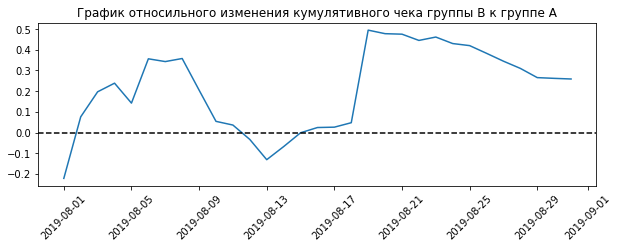

In [15]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date',
                                                   right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(10,3))
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('График относильного изменения кумулятивного чека группы B к группе A')
plt.show()

**Вывод:**

Результаты теста значительно и резко менялись несколько раз, возможно в эти даты и были совершены аномальные заказы.

### Кумулятивная конверсия

Построим график кумулятивной конверсии по группам.

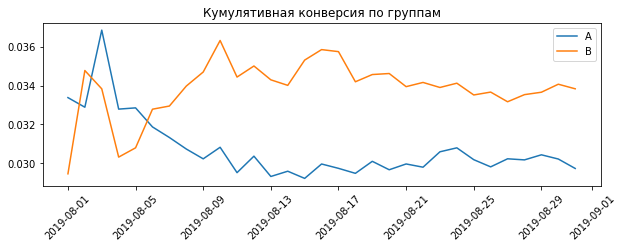

In [16]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(10,3))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная конверсия по группам')
plt.legend()
plt.show()

**Вывод:**

После 5-го августа 2019-го года у группы В конверсия стабильно значительно выше, чем у группы А.

### Относительное изменение кумулятивной конверсии

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

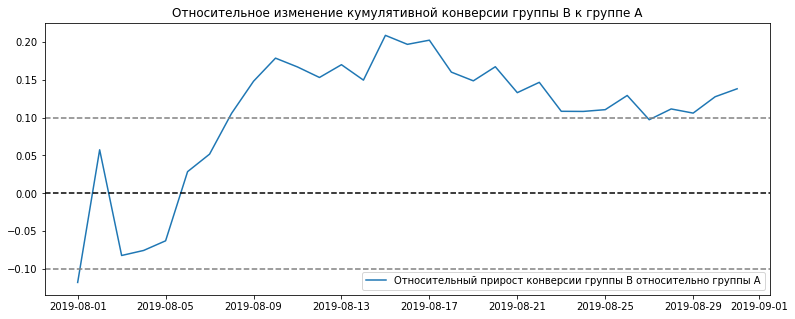

In [17]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
                                  cumulativeDataB[['date','conversion']],
                                  left_on='date', right_on='date', how='left', suffixes=['A', 'B']
                              )

plt.figure(figsize=(13,5))
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.show()

**Вывод:**

К 9 августа 2019-го года конверсия группы В становится на 10% стабильно лучше, чем в группе А.

## Определение аномалий

### Количество заказов по пользователям

Построим точечный график количества заказов по пользователям.

In [18]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


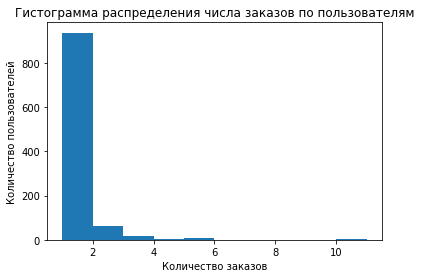

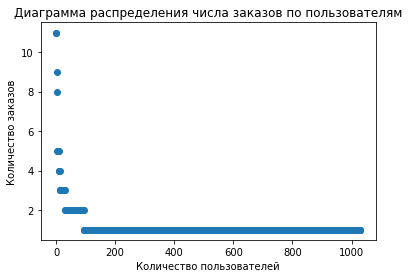

1     937
2      64
3      17
5       6
4       3
11      2
9       1
8       1
Name: orders, dtype: int64

In [19]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
    .sort_values(by='transactionId', ascending=False)
)
ordersByUsers.columns = ['visitorId', 'orders']

plt.hist(ordersByUsers['orders'], bins=10)
plt.title('Гистограмма распределения числа заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Диаграмма распределения числа заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей')
plt.show()
plt.show()

ordersByUsers['orders'].value_counts()

**Вывод:**

У большинства пользователей не более 2 заказов. Однако есть и аномальные пользователи, совершавшиее не менее 4 заказов.

### Перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [20]:
print('95-й перцентиль количества заказов на пользователя:',
      np.percentile(ordersByUsers['orders'], [95])[0])
print('99-й перцентиль количества заказов на пользователя:',
      np.percentile(ordersByUsers['orders'], [99])[0])

95-й перцентиль количества заказов на пользователя: 2.0
99-й перцентиль количества заказов на пользователя: 4.0


**Вывод:** 

Больше 2-х заказов совершают 5% пользователей, больше 4-х заказов - всего 1%.

### Стоимость заказов

Построим точечный график стоимостей заказов.

In [21]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

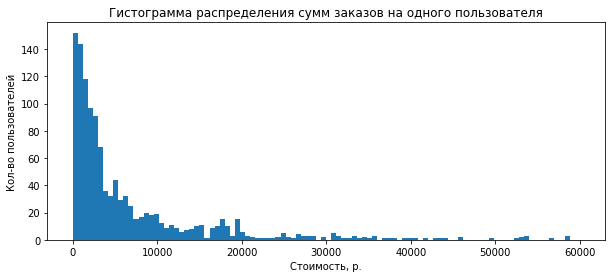

In [22]:
plt.figure(figsize=(10,4))
plt.hist(orders['revenue'], range=(0, 60000), bins=100)
plt.title('Гистограмма распределения сумм заказов на одного пользователя')
plt.xlabel('Стоимость, р.')
plt.ylabel('Кол-во пользователей')
plt.show()

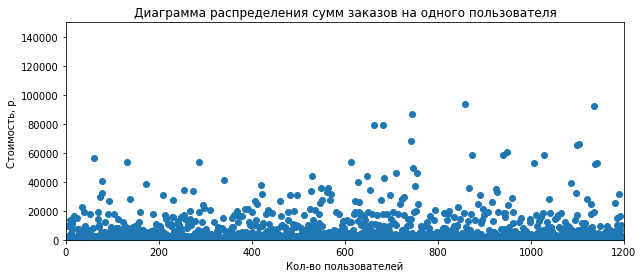

In [23]:
x_values = pd.Series(range(0, len(orders)))

plt.figure(figsize=(10,4))
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 150000])
plt.title('Диаграмма распределения сумм заказов на одного пользователя')
plt.ylabel('Стоимость, р.')
plt.xlabel('Кол-во пользователей')
plt.show()

**Вывод:**

Большинство пользователей совершает заказы не дороже 25 тысяч руб.

### Перцентили сумм заказов на пользователя

Посчитаем 95-й и 99-й перцентили сумм заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [24]:
print('95-й перцентиль количества заказов на пользователя:',
      round(np.percentile(orders['revenue'], [95])[0], 2))
print('99-й перцентиль количества заказов на пользователя:',
      round(np.percentile(orders['revenue'], [99])[0], 2))

95-й перцентиль количества заказов на пользователя: 28000.0
99-й перцентиль количества заказов на пользователя: 58233.2


5% пользователей совершают заказы стоимостью выше 28 тысяч руб., на сумму больше 58 тысяч руб. - всего 1%.

### Статистическая значимость различий в конверсии по "сырым" данным

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [25]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

zerosA = (visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA)) * [0]
without_ordersA = pd.Series(data = zerosA, name = 'orders')

zerosB = (visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB)) * [0]
without_ordersB = pd.Series(data = zerosB, name = 'orders')

sampleA = pd.concat([ordersByUsersA['orders'], without_ordersA], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], without_ordersB], axis=0)

Сформулируем и проверим следующие гипотезы:

**H0** - нулевая гипотеза - статистически значимых различий в конверсии между группами по "сырым" данным нет.

**H1** - альтернативная гипотеза - статистически значимые различия в конверсии между группами по "сырым" данным есть

In [26]:
print('Относительный прирост конверсии группы В по отношению к группе А по "сырым" данным:',
     round(sampleB.mean()/sampleA.mean()-1, 3))
print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB)
if results.pvalue < alpha:
    print('Различия в конверсии между группами по "сырым" данным статистически значимы.')
else:
    print('Различий в конверсии между группами по "сырым" данным нет.')

Относительный прирост конверсии группы В по отношению к группе А по "сырым" данным: 0.138
p-value: 0.00840
Различия в конверсии между группами по "сырым" данным статистически значимы.


### Статистическая значимость различий в среднем чеке по "сырым" данным

Сформулируем и проверим следующие гипотезы:

**H0** - нулевая гипотеза - статистически значимых различий в среднем чеке между группами по "сырым" данным нет.

**H1** - альтернативная гипотеза - статистически значимые различия в среднем чеке между группами по "сырым" данным есть

In [27]:
alpha = 0.05
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
                          
print('Относительный прирост среднего чека группы В по отношению к группе А по "сырым" данным:',
      "{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

print('p-value:',
      '{0:.3f}'.format(results.pvalue))
                             
if results.pvalue < alpha:
    print('Различия в среднем чеке между группами по "сырым" данным статистически значимы.')
else:
    print('Различий в среднем чеке между группами по "сырым" данным нет.')             

Относительный прирост среднего чека группы В по отношению к группе А по "сырым" данным: 0.259
p-value: 0.365
Различий в среднем чеке между группами по "сырым" данным нет.


### Статистическая значимость различий в конверсии по "очищенным" данным

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Более 2-х заказов совершает 5% пользователей, и на сумму больше 28 тысяч руб. покупает тоже только 5%. Возьмем эти данные за границу для определения аномальных пользователей.

In [28]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat([
        ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
        without_ordersA
    ],
    axis=0,
)

sampleBFiltered = pd.concat([
        ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
        without_ordersB
    ],
    axis=0,
) 

Сформулируем и проверим следующие гипотезы:

**H0** - нулевая гипотеза - статистически значимых различий в конверсии между группами по "очищенным" данным нет.

**H1** - альтернативная гипотеза - статистически значимые различия в конверсии между группами по "очищенным" данным есть

In [29]:
print('Относительный прирост конверсии группы В по отношению к группе А по "очищенным" данным:',
     round(sampleBFiltered.mean()/sampleAFiltered.mean()-1, 3))
print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

alpha = 0.05
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
if results.pvalue < alpha:
    print('Различия в конверсии между группами по "очищенным" данным статистически значимы.')
else:
    print('Различий в конверсии между группами по "очищенным" данным нет.')

Относительный прирост конверсии группы В по отношению к группе А по "очищенным" данным: 0.173
p-value: 0.00652
Различия в конверсии между группами по "очищенным" данным статистически значимы.


### Статистическая значимость различий в среднем чеке по "очищенным" данным

Сформулируем и проверим следующие гипотезы:

**H0** - нулевая гипотеза - статистически значимых различий в среднем чеке между группами по "очищенным" данным нет.

**H1** - альтернативная гипотеза - статистически значимые различия в среднем чеке между группами по "очищенным" данным есть

In [30]:
alpha = 0.05
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])
                          
print('Относительный прирост среднего чека в группе B по отношению к группе A по "очищенным" данным: {:.3f}'.format(
orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()\
/orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))

print('p-value:',
      '{0:.3f}'.format(results.pvalue))
                          
if results.pvalue < alpha:
    print('Различия в среднем чеке между группами по "очищенным" данным статистически значимы.')
else:
    print('Различий в среднем чеке между группами по "очищенным" данным нет.')             

Относительный прирост среднего чека в группе B по отношению к группе A по "очищенным" данным: -0.020
p-value: 0.369
Различий в среднем чеке между группами по "очищенным" данным нет.


## Общий вывод

На протяжении всего A/B-теста кумулятивные показатели были лучше в группе В. Даже несмотря на то, что были замечены резкие скачки вверх на графике в группе В, выяснено, что это произошло из-за аномалий. 

После очистки данных конверсия в группе В стала больше на 17%, по отношению к группе А, при том что до очистки этот показатель был равен 14%. Таким образом, можно сделать вывод, что следует остановить A/B-тест и зафиксировать победу группы В.